In [ ]:
import logging
import time
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth
from pyspark import SparkConf
from pyspark.sql.types import ArrayType, StringType

# --- Initialize Logger ---
# Set up basic logging (adjust level and format as needed)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Spark Configuration (assuming you have this configured from previous steps) ---
conf = SparkConf() \
    .setAppName("SARL_Spark_LPA_Partitioning") \
    .setMaster("local[*]") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.instances", "6") \
    .set("spark.executor.cores", "6") \
    .set("spark.memory.offHeap.enabled", "true") \
    .set("spark.memory.offHeap.size", "3g") \
    .set("spark.sql.shuffle.partitions", "200") \
    .set("spark.executor.extraJavaOptions", "-Xss4m") \
    .set("spark.driver.extraJavaOptions", "-Xss4m") \
    .set("spark.executor.memoryOverhead", "2g") \
    .set("spark.driver.memoryOverhead", "2g") \
    .set("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .set("spark.kryoserializer.buffer.max", "512m") \
    .set("spark.memory.fraction", "0.6") \
    .set("spark.memory.storageFraction", "0.5") \
    .set("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext # Get SparkContext for log level setting
sc.setLogLevel("INFO") # Set Spark's own logging level

logger.info(f"Spark Version: {spark.version}")
logger.info(f"Spark Driver Memory: {spark.conf.get('spark.driver.memory')}")
logger.info(f"Spark Executor Memory: {spark.conf.get('spark.executor.memory')}")
logger.info(f"Spark Executor Cores: {spark.conf.get('spark.executor.cores')}")


# --- Load Transactional Data (from previous steps) ---
transaction_file_path = 'sarl-spark/data/processed/transactional_data_zscore.csv'

# Load the raw text file into an RDD
raw_lines_rdd = sc.textFile(transaction_file_path)

# Get the header row. This action will cause Spark to read the first line.
header = raw_lines_rdd.first()
logger.info(f"Header row identified: {header}")

# Filter out the header row from the RDD, then proceed with mapping and filtering
transactions_rdd = raw_lines_rdd.filter(lambda line: line != header) \
                                 .map(lambda line: [item.strip() for item in line.strip().split(',') if item.strip()]) \
                                 .filter(lambda transaction: len(transaction) > 0)

# Convert to DataFrame
transactions_df = spark.createDataFrame(transactions_rdd, ArrayType(StringType()))
transactions_df = transactions_df.withColumnRenamed("value", "items") # Renames the default column 'value' to 'items'
transactions_df.cache()
logger.info(f"Total transactions loaded (after removing header): {transactions_df.count()}")
transactions_df.show(5, truncate=False) # Keep this for initial data check
logger.info("Initial transactions_df displayed.")

2025-06-03 07:30:11,840 - INFO - Spark Version: 3.4.0
2025-06-03 07:30:12,331 - INFO - Spark Driver Memory: 16g
2025-06-03 07:30:12,332 - INFO - Spark Executor Memory: 16g
2025-06-03 07:30:12,332 - INFO - Spark Executor Cores: 6
2025-06-03 07:30:13,434 - INFO - Header row identified: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,2

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Total number of transactions: 2302


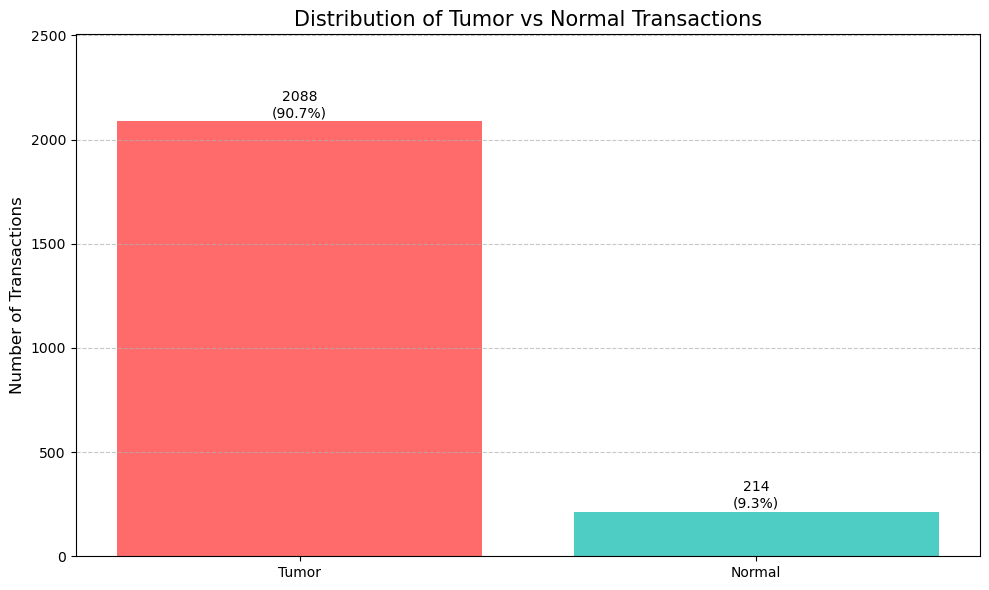

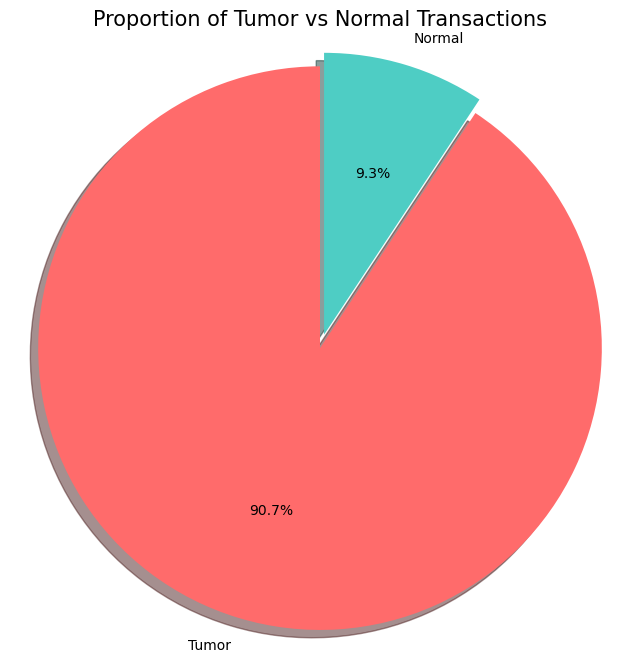

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get counts directly from the data
tumor_count = transactions_df.filter(
    F.array_contains(F.col("items"), "tumor")
).count()

normal_count = transactions_df.filter(
    F.array_contains(F.col("items"), "normal")
).count()

# Data
categories = ['Tumor', 'Normal']
counts = [tumor_count, normal_count]

# Calculate total transactions
total_transactions = transactions_df.count()
print(f"Total number of transactions: {total_transactions}")

# Create figure
plt.figure(figsize=(10, 6))

# Bar chart
bars = plt.bar(categories, counts, color=['#FF6B6B', '#4ECDC4'])

# Add count and percentage labels on top of bars
for bar, count in zip(bars, counts):
    percentage = (count / total_transactions) * 100
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 20,
        f'{count}\n({percentage:.1f}%)',
        ha='center'
    )

# Add title and labels
plt.title('Distribution of Tumor vs Normal Transactions', fontsize=15)
plt.ylabel('Number of Transactions', fontsize=12)
plt.ylim(0, max(counts) * 1.2)  # Add some space for the labels

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Pie chart for proportion
plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=categories,
    autopct='%1.1f%%',
    colors=['#FF6B6B', '#4ECDC4'],
    explode=(0.05, 0),  # Slightly explode the tumor slice
    shadow=True,
    startangle=90
)
plt.title('Proportion of Tumor vs Normal Transactions', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [2]:
from pyspark.sql.functions import explode, count, desc, col # Ensure col is imported if not already

# Assuming 'spark' (SparkSession) and 'transactions_df' are already initialized
# from your previous data loading and preprocessing steps.
# Also assuming 'logger' is configured.

logger.info("Starting to find frequent 1-itemsets.")

# SARL often focuses on frequent single items (1-itemsets) to build the IAG graph.
# This step identifies all unique items and counts their occurrences across transactions.
frequent_single_items_df = transactions_df.select(explode(col("items")).alias("item")) \
    .groupBy("item") \
    .agg(count("*").alias("frequency")) \
    .orderBy(desc("frequency"))

logger.info("Raw frequent single items (before filtering by min_support):")
frequent_single_items_df.show(5, truncate=False) # Show top 5 for a quick check

# Calculate minsup in absolute counts.
# This requires knowing the total number of transactions.
total_transactions = transactions_df.count()
logger.info(f"Total transactions for min_support calculation: {total_transactions}")

min_support_percentage = 0.03 # Example: 1% minimum support. Adjust this value as needed.
min_support_count = total_transactions * min_support_percentage
logger.info(f"Minimum support count (absolute): {min_support_count}")

# Filter for actually frequent 1-itemsets based on the calculated min_support_count.
# These are the items that appear at least 'min_support_count' times in the dataset.
frequent_single_items_filtered_df = frequent_single_items_df.filter(col("frequency") >= min_support_count)

logger.info("Frequent 1-itemsets (after filtering by min_support):")
frequent_single_items_filtered_df.show(truncate=False)

logger.info("Finished finding frequent 1-itemsets.")

# The commented-out FPGrowth section is indeed for a full FIM pass,
# which SARL aims to avoid globally at this stage, so it remains commented.
# fp_growth_model = FPGrowth(itemsCol="items", minSupport=min_support_percentage, minConfidence=0.0)
# model = fp_growth_model.fit(transactions_df)
# frequent_itemsets_from_fpgrowth = model.freqItemsets
# frequent_itemsets_from_fpgrowth.show()

# Do NOT call spark.stop() here. It should be called once at the end of your entire Spark application.

2025-06-02 14:58:39,601 - INFO - Starting to find frequent 1-itemsets.
2025-06-02 14:58:39,654 - INFO - Raw frequent single items (before filtering by min_support):
2025-06-02 14:58:40,416 - INFO - Total transactions for min_support calculation: 2302
2025-06-02 14:58:40,417 - INFO - Minimum support count (absolute): 69.06
2025-06-02 14:58:40,430 - INFO - Frequent 1-itemsets (after filtering by min_support):


+--------+---------+
|item    |frequency|
+--------+---------+
|tumor   |2088     |
|normal  |214      |
|+MAGEA6 |185      |
|+COL2A1 |170      |
|+HORMAD1|170      |
+--------+---------+
only showing top 5 rows



2025-06-02 14:58:40,786 - INFO - Finished finding frequent 1-itemsets.


+---------+---------+
|item     |frequency|
+---------+---------+
|tumor    |2088     |
|normal   |214      |
|+MAGEA6  |185      |
|+COL2A1  |170      |
|+HORMAD1 |170      |
|+BRINP3  |168      |
|+NXPH1   |168      |
|+GRIA2   |166      |
|+CLCA2   |166      |
|+BEX1    |165      |
|+CT83    |163      |
|+PVALB   |162      |
|+TDRD12  |162      |
|+DHRS2   |161      |
|+IGF2BP3 |159      |
|+SERPINA6|159      |
|+SLC30A8 |158      |
|+PCAT18  |158      |
|+NKX2-2  |158      |
|+GPAT2   |157      |
+---------+---------+
only showing top 20 rows



In [3]:
from pyspark.sql.functions import col, explode, split, trim, array_distinct, array_sort, size, count, lit, array_contains, udf, monotonically_increasing_id
from pyspark.sql.types import ArrayType, StringType, StructType, StructField, LongType # Changed IntegerType to LongType for 'weight'
from itertools import combinations
from graphframes import GraphFrame
import os # To check for local file system paths

# Assuming 'spark', 'sc', 'logger', 'transactions_df', and
# 'frequent_single_items_filtered_df' are already initialized from previous steps.

# --- Define Paths for Persistent Storage ---
# Use paths on your filesystem where Spark can read/write.
# For 'local[*]' master, these can be local paths (e.g., in your project directory).
# For cluster modes (YARN, K8s), use distributed file system paths (e.g., "hdfs:///user/spark/data/iag_vertices.parquet", "s3a://your-bucket/data/iag_edges.parquet")
IAG_VERTICES_SAVE_PATH = "iag_data/vertices3.parquet"
IAG_EDGES_SAVE_PATH = "iag_data/edges3.parquet"

# Set up checkpointing (optional, but good for long lineages)
checkpoint_dir = "/tmp/spark-checkpoint"
spark.sparkContext.setCheckpointDir(checkpoint_dir)
logger.info(f"Spark Checkpoint directory set to: {checkpoint_dir}")

# --- Helper function to check if Spark path exists ---
def spark_path_exists(spark_session, path):
    """Checks if a path exists in Spark's configured file system."""
    try:
        # Use Spark's JVM to access Hadoop FileSystem utilities
        hadoop_conf = spark_session._jsc.hadoopConfiguration()
        fs = spark_session._jvm.org.apache.hadoop.fs.FileSystem.get(hadoop_conf)
        return fs.exists(spark_session._jvm.org.apache.hadoop.fs.Path(path))
    except Exception as e:
        logger.warning(f"Could not check path existence for {path}: {e}")
        return False

logger.info("Starting IAG Graph Construction (Step 4.3).")

# --- Try to load existing IAG Vertices and Edges ---
iag_vertices_df = None
iag_edges_df = None

if spark_path_exists(spark, IAG_VERTICES_SAVE_PATH) and spark_path_exists(spark, IAG_EDGES_SAVE_PATH):
    logger.info(f"Found existing IAG Vertices and Edges at {IAG_VERTICES_SAVE_PATH} and {IAG_EDGES_SAVE_PATH}.")
    try:
        iag_vertices_df = spark.read.parquet(IAG_VERTICES_SAVE_PATH)
        iag_edges_df = spark.read.parquet(IAG_EDGES_SAVE_PATH)

        # Cache them immediately if they are loaded, for faster subsequent operations
        iag_vertices_df.cache()
        iag_edges_df.cache()

        vertex_count = iag_vertices_df.count()
        edge_count = iag_edges_df.count()
        logger.info(f"Successfully loaded {vertex_count} vertices and {edge_count} edges from persistent storage.")
        iag_vertices_df.show(5, truncate=False)
        iag_edges_df.show(5, truncate=False)

    except Exception as e:
        logger.error(f"Error loading saved IAG DataFrames: {e}. Recomputing from scratch.")
        iag_vertices_df = None # Reset to recompute
        iag_edges_df = None
else:
    logger.info("IAG Vertices and/or Edges not found in persistent storage. Generating from scratch.")


# --- If not loaded, generate IAG from scratch ---
if iag_vertices_df is None or iag_edges_df is None:
    # --- 1. Prepare Vertices DataFrame ---
    iag_vertices_df = frequent_single_items_filtered_df.select(col("item").alias("id"))
    iag_vertices_df.cache()
    vertex_count = iag_vertices_df.count()
    logger.info(f"IAG Vertices loaded: {vertex_count} unique frequent items.")
    iag_vertices_df.show(5, truncate=False)

    # Checkpoint vertices
    iag_vertices_df.checkpoint()
    logger.info("Vertices DataFrame checkpointed.")

    # --- 2. Prepare Edges DataFrame (Co-occurrence between ALL frequent items) ---

    # Get the set of all frequent items and broadcast it.
    frequent_items_set = spark.sparkContext.broadcast(
        set(frequent_single_items_filtered_df.select("item").rdd.map(lambda r: r[0]).collect())
    )
    logger.info(f"Broadcasted {len(frequent_items_set.value)} frequent items for efficient filtering.")

    # Define a UDF to filter the 'items' array in each transaction, keeping only frequent items.
    @udf(ArrayType(StringType()))
    def filter_to_frequent_items_udf(items_list):
        if items_list is None:
            return []
        return [item for item in items_list if item in frequent_items_set.value]

    logger.info("Filtering transactions to include only frequent items using UDF.")

    filtered_transactions_df = transactions_df.select(
        monotonically_increasing_id().alias("transaction_id"),
        filter_to_frequent_items_udf(col("items")).alias("frequent_items")
    ).filter(size(col("frequent_items")) >= 2)

    filtered_transactions_df.cache()
    transactions_for_edges_count = filtered_transactions_df.count()
    logger.info(f"Transactions filtered for edge generation: {transactions_for_edges_count} transactions remaining with >= 2 frequent items.")
    filtered_transactions_df.show(5, truncate=False)

    logger.info("Generating candidate item co-occurrence pairs via explode and self-join.")

    item_occurrences_df = filtered_transactions_df.select(
        col("transaction_id"),
        explode(col("frequent_items")).alias("item")
    )

    candidate_edges_df = item_occurrences_df.alias("a").join(
        item_occurrences_df.alias("b"),
        (col("a.transaction_id") == col("b.transaction_id")) &
        (col("a.item") < col("b.item"))
    ).select(
        col("a.item").alias("src"),
        col("b.item").alias("dst")
    )

    iag_edges_df = candidate_edges_df.groupBy("src", "dst").agg(count("*").alias("weight"))

    iag_edges_df.cache()
    edge_count = iag_edges_df.count()
    logger.info(f"IAG Edges generated and computed: {edge_count} edges.")
    iag_edges_df.show(5, truncate=False)

    # --- Save the generated DataFrames for future runs ---
    logger.info(f"Saving IAG Vertices to {IAG_VERTICES_SAVE_PATH}")
    # Use "overwrite" mode if you want to replace existing files on subsequent runs
    iag_vertices_df.write.mode("overwrite").parquet(IAG_VERTICES_SAVE_PATH)
    logger.info(f"Saving IAG Edges to {IAG_EDGES_SAVE_PATH}")
    iag_edges_df.write.mode("overwrite").parquet(IAG_EDGES_SAVE_PATH)
    logger.info("IAG Vertices and Edges saved successfully.")

    # Unpersist temporary DataFrame if it was cached
    filtered_transactions_df.unpersist()


# --- 3. Create the GraphFrame ---
logger.info("Attempting to create GraphFrame.")
# Correct way to initialize GraphFrame:
iag_graph = GraphFrame(iag_vertices_df, iag_edges_df)
logger.info(f"GraphFrame created with {iag_graph.vertices.count()} vertices and {iag_graph.edges.count()} edges.")
logger.info("IAG Graph Construction completed.")
# Unpersist final cached DataFrames if no longer needed after GraphFrame creation
# (GraphFrame might internalize them, but good practice to release explicit caches)
iag_vertices_df.unpersist()
iag_edges_df.unpersist()

# Remember to clear the checkpoint directory when done with the entire application
# (This can be done at the very end of your script or manually if needed)
# import shutil
# shutil.rmtree(checkpoint_dir) # For local filesystem
# If running on Databricks, use dbutils.fs.rm(checkpoint_dir, True)

2025-06-02 14:59:28,743 - INFO - Spark Checkpoint directory set to: /tmp/spark-checkpoint
2025-06-02 14:59:28,744 - INFO - Starting IAG Graph Construction (Step 4.3).
2025-06-02 14:59:28,750 - INFO - IAG Vertices and/or Edges not found in persistent storage. Generating from scratch.
2025-06-02 14:59:31,431 - INFO - IAG Vertices loaded: 13573 unique frequent items.


+--------+
|id      |
+--------+
|tumor   |
|normal  |
|+MAGEA6 |
|+COL2A1 |
|+HORMAD1|
+--------+
only showing top 5 rows



2025-06-02 14:59:31,803 - INFO - Vertices DataFrame checkpointed.
2025-06-02 14:59:32,281 - INFO - Broadcasted 13573 frequent items for efficient filtering.
2025-06-02 14:59:32,282 - INFO - Filtering transactions to include only frequent items using UDF.
2025-06-02 14:59:33,445 - INFO - Transactions filtered for edge generation: 2302 transactions remaining with >= 2 frequent items.
2025-06-02 14:59:33,551 - INFO - Generating candidate item co-occurrence pairs via explode and self-join.


+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2025-06-02 15:04:26,489 - INFO - IAG Edges generated and computed: 88678637 edges.
2025-06-02 15:04:26,575 - INFO - Saving IAG Vertices to iag_data/vertices3.parquet


+---------+----------+------+
|src      |dst       |weight|
+---------+----------+------+
|+LEAP2   |+MIF-AS1  |8     |
|+LEAP2   |+WSB2     |2     |
|+LEAP2   |+XRRA1    |7     |
|+FLJ30679|+NASP     |3     |
|+DCD     |+LOC400541|4     |
+---------+----------+------+
only showing top 5 rows



2025-06-02 15:04:27,752 - INFO - Saving IAG Edges to iag_data/edges3.parquet
2025-06-02 15:04:44,992 - INFO - IAG Vertices and Edges saved successfully.
2025-06-02 15:04:45,021 - INFO - Attempting to create GraphFrame.
2025-06-02 15:04:45,593 - INFO - GraphFrame created with 13573 vertices and 88678637 edges.
2025-06-02 15:04:45,593 - INFO - IAG Graph Construction completed.


DataFrame[src: string, dst: string, weight: bigint]

In [4]:
# Check basic graph properties
print("Vertices count:", iag_graph.vertices.count())
print("Edges count:", iag_graph.edges.count())

# Examine schema
print("\nVertices schema:")
iag_graph.vertices.printSchema()

print("\nEdges schema:")
iag_graph.edges.printSchema()

# Check degree distribution
in_degrees = iag_graph.inDegrees
out_degrees = iag_graph.outDegrees
degrees = iag_graph.degrees

print("\nIn-degree statistics:")
in_degrees.describe().show()

print("Out-degree statistics:")
out_degrees.describe().show()

print("Total degree statistics:")
degrees.describe().show()

# Check for isolated vertices (degree = 0)
isolated_vertices = degrees.filter(col("degree") == 0).count()
print(f"Isolated vertices: {isolated_vertices} ({isolated_vertices/iag_graph.vertices.count()*100:.2f}%)")

# Sample vertices and edges
print("\nSample vertices:")
iag_graph.vertices.show(5, truncate=False)

print("\nSample edges:")
iag_graph.edges.show(5, truncate=False)

# Check if all edge endpoints exist in vertices
src_not_in_vertices = iag_graph.edges.join(
    iag_graph.vertices,
    iag_graph.edges.src == iag_graph.vertices.id,
    "left_anti"
).count()

dst_not_in_vertices = iag_graph.edges.join(
    iag_graph.vertices,
    iag_graph.edges.dst == iag_graph.vertices.id,
    "left_anti"
).count()

print(f"\nEdges with src not in vertices: {src_not_in_vertices}")
print(f"Edges with dst not in vertices: {dst_not_in_vertices}")

# Test if other graph algorithms work
try:
    print("\nTesting triangle count:")
    triangle_count = iag_graph.triangleCount()
    triangle_count.select("id", "count").show(5)
    print("Triangle count successful")
except Exception as e:
    print("Triangle count failed:", str(e))

Vertices count: 13573
Edges count: 88678637

Vertices schema:
root
 |-- id: string (nullable = true)


Edges schema:
root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- weight: long (nullable = false)


In-degree statistics:


2025-06-02 15:14:19,376 - ERROR - KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
2025-06-02 15:14:19,379 - INFO - Closing down clientserver connection


KeyboardInterrupt: 

In [ ]:
# Test if other graph algorithms work
connected_components = iag_graph.connectedComponents()
connected_components.show(5)

# Create a smaller test graph
test_vertices = iag_graph.vertices.limit(10000)
test_edges = iag_graph.edges.join(test_vertices,
                                 iag_graph.edges.src == test_vertices.id).join(
                                 test_vertices,
                                 iag_graph.edges.dst == test_vertices.id)
test_graph = GraphFrame(test_vertices, test_edges)

# Try LPA on smaller graph
test_lpa = test_graph.labelPropagation(maxIter=5)

+----------+---------+
|        id|component|
+----------+---------+
|     +RIC3|        0|
|+LOC340090|        0|
|     +TFPT|        0|
|  +ZFAND2B|        0|
|   +SLC2A5|        0|
+----------+---------+
only showing top 5 rows



AnalysisException: Column id#174 are ambiguous. It's probably because you joined several Datasets together, and some of these Datasets are the same. This column points to one of the Datasets but Spark is unable to figure out which one. Please alias the Datasets with different names via `Dataset.as` before joining them, and specify the column using qualified name, e.g. `df.as("a").join(df.as("b"), $"a.id" > $"b.id")`. You can also set spark.sql.analyzer.failAmbiguousSelfJoin to false to disable this check.

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 41620)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/

In [ ]:
from pyspark.sql.functions import col
from graphframes import GraphFrame # Make sure you have GraphFrames installed and available to Spark

# Assuming 'spark', 'sc', 'logger', and 'iag_graph' are already initialized.

logger.info("Starting Graph Partitioning using Label Propagation Algorithm (Step 4.4).")

# --- 1. Run Label Propagation Algorithm (LPA) ---
# LPA is an iterative algorithm. You typically need to define the maximum number of iterations.
# A higher number of iterations allows labels to propagate further, potentially leading to fewer, larger communities.
# A lower number might result in more, smaller communities.
# You might need to experiment with 'maxIter' for optimal results for your dataset and desired partition size.

# Given your extremely large number of edges (457+ million), LPA will be computationally intensive.
# Start with a conservative maxIter, e.g., 5-10.
max_lpa_iterations = 8 # You can adjust this value

logger.info(f"Running Label Propagation Algorithm with maxIter={max_lpa_iterations}...")
lpa_result = iag_graph.labelPropagation(maxIter=max_lpa_iterations)

# The result is a DataFrame where each vertex has a 'label' column, indicating its community ID.
# The label is a LongType value.
logger.info(f"Label Propagation Algorithm completed in {max_lpa_iterations} iterations.")
logger.info("Sample of LPA results (vertices with their assigned community labels):")
lpa_result.show(5, truncate=False) # 'id' is your item, 'label' is its community ID


# --- 2. Analyze Partitions (Highly Recommended) ---
# Understand the size and distribution of your communities.
# This helps confirm if LPA is creating meaningful partitions for your downstream FPGrowth.

logger.info("Analyzing distribution of community sizes (partitions):")
partition_counts = lpa_result.groupBy("label").count().orderBy(col("count").desc())
partition_counts.show(10) # Show top 10 largest partitions

# Calculate summary statistics for partition sizes
min_partition_size = partition_counts.agg({"count": "min"}).collect()[0][0]
max_partition_size = partition_counts.agg({"count": "max"}).collect()[0][0]
avg_partition_size = partition_counts.agg({"count": "avg"}).collect()[0][0]
total_partitions = partition_counts.count()
logger.info(f"Total number of partitions (communities) found: {total_partitions}")
logger.info(f"Min partition size: {min_partition_size}")
logger.info(f"Max partition size: {max_partition_size}")
logger.info(f"Avg partition size: {avg_partition_size}")

# --- 3. Store Partitioning Results ---
# This DataFrame maps each frequent item ('id') to its assigned partition 'label'.
# It will be crucial for the next step (Nội dung 4.5) to assign transactions to partitions.
item_to_partition_mapping_df = lpa_result.select(col("id").alias("item"), col("label").alias("partition_id"))
item_to_partition_mapping_df.cache() # Cache for efficient reuse in next step
logger.info(f"Item-to-partition mapping created and cached: {item_to_partition_mapping_df.count()} entries.")
item_to_partition_mapping_df.show(5)

# You might want to save this mapping to disk, especially if you need to rerun parts of the pipeline
# without recomputing LPA (which can be very costly).
# Example:
# item_to_partition_mapping_path = "sarl_data/item_partition_mapping.parquet"
# logger.info(f"Saving item-to-partition mapping to {item_to_partition_mapping_path}")
# item_to_partition_mapping_df.write.mode("overwrite").parquet(item_to_partition_mapping_path)
# logger.info("Item-to-partition mapping saved.")


logger.info("Graph Partitioning (Step 4.4) completed.")

2025-06-02 07:17:33,952 - INFO - Starting Graph Partitioning using Label Propagation Algorithm (Step 4.4).
2025-06-02 07:17:33,953 - INFO - Running Label Propagation Algorithm with maxIter=8...
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 53070)
2025-06-02 07:21:09,073 - INFO - Error while receiving.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty
2025-06-02 07:21:09,076 - INFO - Closing down clientserver connection
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_addr

Py4JError: An error occurred while calling o185.run

2025-06-02 07:21:09,984 - INFO - Error while receiving.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty
2025-06-02 07:21:09,984 - INFO - Closing down clientserver connection
2025-06-02 07:21:09,985 - ERROR - Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/l

In [4]:
# from pyspark.sql.functions import col, explode, split, trim, array_distinct, array_sort, size, count, lit, array_contains, udf, monotonically_increasing_id
# from pyspark.sql.types import ArrayType, StringType, StructType, StructField, IntegerType
# from itertools import combinations
# from graphframes import GraphFrame # Make sure you have GraphFrames installed and available to Spark

# # Assuming 'spark', 'sc', 'logger', 'transactions_df', and
# # 'frequent_single_items_filtered_df' are already initialized from previous steps.

# # Set up checkpointing
# checkpoint_dir = "/tmp/spark-checkpoint"
# spark.sparkContext.setCheckpointDir(checkpoint_dir)

# logger.info("Starting IAG Graph Construction (Step 4.3) with optimized approach.")

# # --- 1. Prepare Vertices DataFrame ---
# iag_vertices_df = frequent_single_items_filtered_df.select(col("item").alias("id"))
# iag_vertices_df.cache()
# vertex_count = iag_vertices_df.count()
# logger.info(f"IAG Vertices loaded: {vertex_count} unique frequent items.")
# iag_vertices_df.show(5, truncate=False)

# # Checkpoint vertices
# iag_vertices_df.checkpoint()
# logger.info("Vertices DataFrame checkpointed.")

# # --- 2. Prepare Edges DataFrame with batch processing ---
# # Get the list of frequent items
# frequent_items_list = frequent_single_items_filtered_df.select("item").rdd.map(lambda r: r[0]).collect()
# logger.info(f"Collected {len(frequent_items_list)} frequent items.")

# # Define batch size and calculate total batches
# batch_size = 1000  # Adjust based on your memory constraints
# total_batches = (len(frequent_items_list) + batch_size - 1) // batch_size
# logger.info(f"Will process in {total_batches} batches of up to {batch_size} items each.")

# # Initialize empty edges DataFrame
# edge_schema = StructType([
#     StructField("src", StringType(), False),
#     StructField("dst", StringType(), False),
#     StructField("weight", IntegerType(), False)
# ])
# all_edges_df = spark.createDataFrame([], edge_schema)

# # Process each batch
# for batch_idx in range(total_batches):
#     start_idx = batch_idx * batch_size
#     end_idx = min((batch_idx + 1) * batch_size, len(frequent_items_list))
#     current_batch = frequent_items_list[start_idx:end_idx]

#     logger.info(f"Processing batch {batch_idx+1}/{total_batches} with {len(current_batch)} items")

#     # Method 1: Using explode and join approach (more efficient for large datasets)
#     # Create item occurrence DataFrame for this batch
#     item_occurrences = transactions_df.select(
#         monotonically_increasing_id().alias("transaction_id"),
#         explode(col("items")).alias("item")
#     ).filter(col("item").isin(current_batch))

#     item_occurrences_count = item_occurrences.count()
#     logger.info(f"Batch {batch_idx+1}: Found {item_occurrences_count} item occurrences")

#     # Self-join to find co-occurring items
#     batch_edges = item_occurrences.alias("a").join(
#         item_occurrences.alias("b"),
#         (col("a.transaction_id") == col("b.transaction_id")) &
#         (col("a.item") < col("b.item"))  # Ensures we get each pair only once
#     ).select(
#         col("a.item").alias("src"),
#         col("b.item").alias("dst")
#     ).groupBy("src", "dst").count().withColumnRenamed("count", "weight")

#     # Union with main edges DataFrame
#     all_edges_df = all_edges_df.union(batch_edges)

#     # Checkpoint periodically
#     if (batch_idx + 1) % 5 == 0 or batch_idx == total_batches - 1:
#         all_edges_df.cache()
#         all_edges_df.checkpoint()
#         edge_count = all_edges_df.count()
#         logger.info(f"Processed {batch_idx+1}/{total_batches} batches. Current edge count: {edge_count}")

#         # Clean up to free memory
#         spark.catalog.clearCache()

# # Final edges DataFrame
# iag_edges_df = all_edges_df
# iag_edges_df.cache()
# edge_count = iag_edges_df.count()
# logger.info(f"IAG Edges generated and checkpointed: {edge_count} edges.")
# iag_edges_df.show(5, truncate=False)

# # --- 3. Create the GraphFrame ---
# iag_graph = GraphFrame(iag_vertices_df, iag_edges_df)
# logger.info(f"GraphFrame created with {vertex_count} vertices and {edge_count} edges.")
# logger.info("IAG Graph Construction completed.")

# # Unpersist cached DataFrames if no longer needed
# iag_vertices_df.unpersist()
# iag_edges_df.unpersist()

In [5]:
# from pyspark.sql.functions import col, explode, split, trim, array_distinct, array_sort, size, count, lit, array_contains, udf
# from pyspark.sql.types import ArrayType, StringType
# from itertools import combinations
# from graphframes import GraphFrame # Make sure you have GraphFrames installed and available to Spark

# # Assuming 'spark', 'sc', 'logger', 'transactions_df', and
# # 'frequent_single_items_filtered_df' are already initialized from previous steps.

# logger.info("Starting IAG Graph Construction (Step 4.3).")

# # --- 1. Prepare Vertices DataFrame ---
# iag_vertices_df = frequent_single_items_filtered_df.select(col("item").alias("id"))
# iag_vertices_df.cache()
# logger.info(f"IAG Vertices loaded: {iag_vertices_df.count()} unique frequent items.")
# iag_vertices_df.show(5, truncate=False)


# # --- 2. Prepare Edges DataFrame (Co-occurrence between frequent items) ---

# # Convert the filtered frequent items to a broadcast variable for efficient lookup
# frequent_items_list = frequent_single_items_filtered_df.select("item").rdd.map(lambda r: r[0]).collect()
# frequent_items_broadcast = spark.sparkContext.broadcast(set(frequent_items_list))
# logger.info(f"Broadcasted {len(frequent_items_list)} frequent items.")


# # Define the UDF correctly
# # The UDF will receive a Python list (the content of the 'items' column for each row)
# # directly as its 'items_list' argument, not a Spark Column object.
# @udf(returnType=ArrayType(ArrayType(StringType())))
# def generate_frequent_item_pairs(items_list_from_column): # Renamed for clarity within UDF
#     if items_list_from_column is None:
#         return []

#     # Filter transaction items to only include those that are frequent (from our broadcast set)
#     # The 'items_list_from_column' is already a Python list here.
#     filtered_items = [item for item in items_list_from_column if item in frequent_items_broadcast.value]

#     if len(filtered_items) < 2: # Need at least two frequent items to form a pair
#         return []

#     # Sort items for consistent pair generation (e.g., ('A','B') not ('B','A'))
#     sorted_items = sorted(filtered_items)

#     # Generate all unique combinations (pairs) from the sorted frequent items in this transaction
#     return [[i[0], i[1]] for i in combinations(sorted_items, 2)]

# logger.info("Generating frequent item pairs for IAG edges.")

# # Apply the UDF
# item_pairs_df = transactions_df.filter(size(col("items")) >= 2) \
#                                .withColumn("pairs", generate_frequent_item_pairs(col("items"))) \
#                                .filter(size(col("pairs")) > 0) \
#                                .select(explode(col("pairs")).alias("pair"))

# # Count co-occurrences to get edge weights
# iag_edges_df = item_pairs_df.groupBy(col("pair")[0].alias("src"), col("pair")[1].alias("dst")) \
#                             .agg(count("*").alias("weight"))

# iag_edges_df.cache()
# logger.info(f"IAG Edges generated: {iag_edges_df.count()} edges.")
# iag_edges_df.show(5, truncate=False)


# # --- 3. Create the GraphFrame ---
# iag_graph = GraphFrame(iag_vertices_df, iag_edges_df)

# logger.info(f"GraphFrame created with {iag_graph.vertices.count()} vertices and {iag_graph.edges.count()} edges.")
# logger.info("IAG Graph Construction completed.")

# # Unpersist cached DataFrames if no longer needed
# iag_vertices_df.unpersist()
# iag_edges_df.unpersist()

In [6]:
# min_support = 0.01
# logger.info("Step 2 (Parallel counting): Generating global F-List.")
# start_time_step2 = time.time()

# # Count frequencies of all individual items
# item_counts_df = transactions_df.select(F.explode("items").alias("item")) \
#                                 .groupBy("item").count()

# # Calculate min_count based on min_support
# total_transactions = transactions_df.count()
# min_count = total_transactions * min_support
# logger.info(f"Total transactions: {total_transactions}, Minimum count for frequent items: {min_count:.2f}")

# # Filter for frequent items and sort to create F-List
# f_list_df = item_counts_df.filter(F.col("count") >= min_count) \
#                           .orderBy(F.col("count").desc())
# f_list_df.cache() # Cache the F-List as it will be used repeatedly

# logger.info("Global F-List (first 10):")
# f_list_df.show(10, truncate=False)
# num_frequent_items_global = f_list_df.count()
# logger.info(f"Number of global frequent items (F-List): {num_frequent_items_global}")
# if num_frequent_items_global == 0:
#     logger.error("No global frequent items found. Consider lowering min_support or checking data quality.")
#     spark.stop()
#     exit(1)

# # Collect F-List items to driver for grouping. This could be memory intensive if F-List is HUGE.
# # If num_frequent_items_global is too large, you might need to adjust min_support slightly.
# global_frequent_items = [row.item for row in f_list_df.collect()]
# logger.info(f"Collected {len(global_frequent_items)} global frequent items to driver.")

# end_time_step2 = time.time()
# logger.info(f"Step 2 completed in {end_time_step2 - start_time_step2:.2f} seconds.")


# logger.info("Step 3 (EBPFP grouping): Creating G-List.")
# start_time_step3 = time.time()

# # Determine N (number of groups)
# # A good heuristic is to use the total number of executor cores or twice that,
# # or simply a fixed number based on experimentation.
# num_cores = 6
# N_groups = max(1, num_cores) * 2 # A common strategy: 2 groups per core, adjust as needed

# # Create G-List: Map each frequent item to a group ID
# # A simple hash-based grouping
# g_list = {}
# for i, item in enumerate(global_frequent_items):
#     group_id = i % N_groups # Simple round-robin or hash(item) % N_groups
#     if group_id not in g_list:
#         g_list[group_id] = []
#     g_list[group_id].append(item)

# logger.info(f"Created {len(g_list)} groups (G-List) for {num_frequent_items_global} frequent items.")

# end_time_step3 = time.time()
# logger.info(f"Step 3 completed in {end_time_step3 - start_time_step3:.2f} seconds.")

# logger.info("Step 4 (Group-oriented datasets): Creating group-dependent transaction datasets.")
# start_time_step4 = time.time()

# group_dependent_transactions = {}
# for group_id, items_in_group in g_list.items():
#     # Convert list of items in group to a set for efficient lookup
#     items_set = set(items_in_group)

#     # Filter transactions:
#     # 1. Keep only items that are in the current group
#     # 2. Ensure the filtered transaction is not empty
#     # This involves a UDF or higher-order function to filter the array.
#     @F.udf("array<string>")
#     def filter_items_by_group(transaction_items):
#         if transaction_items is None:
#             return []
#         return [item for item in transaction_items if item in items_set]

#     group_tx_df = transactions_df.withColumn("filtered_items", filter_items_by_group(F.col("items"))) \
#                                  .filter(F.size(F.col("filtered_items")) > 0) \
#                                  .select(F.col("filtered_items").alias("items"))

#     group_tx_df.cache() # Cache each group's DataFrame
#     group_dependent_transactions[group_id] = group_tx_df
#     logger.info(f"Group {group_id}: Generated group-dependent transactions. Count: {group_tx_df.count()}")

# end_time_step4 = time.time()
# logger.info(f"Step 4 completed in {end_time_step4 - start_time_step4:.2f} seconds.")
# logger.info("Step 5 (Parallel-enhanced FP-Growth): Running FPGrowth for each group.")
# start_time_step5 = time.time()

# local_frequent_patterns = {}

# # Use Spark's parallel capabilities (e.g., via RDD.mapPartitions or multiprocessing if running on local mode
# # where you want to explicitly launch multiple Python processes for this step)
# # For simplicity in a notebook, we can just iterate.
# # In a true cluster, this would involve submitting multiple small jobs or using something like spark-submit.
# # If running in local[*], the jobs will implicitly parallelize across cores.

# for group_id, group_tx_df in group_dependent_transactions.items():
#     if group_tx_df.count() == 0: # Skip empty groups
#         logger.warning(f"Skipping empty group-dependent dataset for group {group_id}.")
#         continue

#     logger.info(f"Running FPGrowth for Group {group_id}...")
#     try:
#         # Use the same global min_support for consistency, or a slightly lower one for local patterns.
#         # For simplicity, stick to global min_support for now.
#         local_fp_growth_model = FPGrowth(itemsCol="items", minSupport=min_support)
#         local_model = local_fp_growth_model.fit(group_tx_df)
#         local_frequent_patterns[group_id] = local_model.freqItemsets
#         local_model.freqItemsets.cache() # Cache results for this group
#         logger.info(f"FPGrowth completed for Group {group_id}. Found {local_model.freqItemsets.count()} patterns.")
#     except Exception as e:
#         logger.error(f"Error running FPGrowth for Group {group_id}: {e}", exc_info=True)
#         # Decide if you want to stop or continue with other groups
#         continue

# end_time_step5 = time.time()
# logger.info(f"Step 5 completed in {end_time_step5 - start_time_step5:.2f} seconds.")

# logger.info("Step 6 (Aggregating): Aggregating local frequent patterns.")
# start_time_step6 = time.time()

# if not local_frequent_patterns:
#     logger.warning("No local frequent patterns found to aggregate.")
#     global_frequent_itemsets_df = spark.createDataFrame([], model.freqItemsets.schema) # Empty DataFrame
# else:
#     # Union all local frequent pattern DataFrames
#     all_local_frequent_dfs = list(local_frequent_patterns.values())
#     global_frequent_itemsets_df = all_local_frequent_dfs[0]
#     for i in range(1, len(all_local_frequent_dfs)):
#         global_frequent_itemsets_df = global_frequent_itemsets_df.union(all_local_frequent_dfs[i])

#     # Since local FP-Growth was run with global min_support on filtered transactions,
#     # the 'freq' column already represents the count within those filtered transactions.
#     # To get true global support, you might need to re-count on the full dataset or adjust here.
#     # However, if items in groups are truly disjoint, and min_support applied to original transactions,
#     # a simple union might be sufficient if the definition of 'freq' carries through.
#     # For a robust solution, you might need to re-evaluate global frequencies for items that appear across groups
#     # or handle overlaps if your grouping strategy isn't strictly disjoint.
#     # For now, let's assume the union is the aggregated result.

#     # Remove duplicates from the unioned DataFrame, as the same itemset could appear in multiple groups
#     # if transactions contained items from different groups. The paper implies disjoint groups,
#     # but in practice, an itemset like {A, B} where A is in group1 and B is in group2, would need careful handling.
#     # For now, assume a simple distinct on (items, freq) or re-aggregation of freq.
#     # For true global frequent itemsets, you might need to run a final pass:
#     # global_frequent_itemsets_df = global_frequent_itemsets_df.groupBy("items").agg(F.sum("freq").alias("freq"))
#     # global_frequent_itemsets_df = global_frequent_itemsets_df.filter(F.col("freq") >= min_count)

#     # For simpler aggregation, let's assume the model.freqItemsets gives us what we need, and distinct them.
#     # The actual paper's aggregation step might be more nuanced depending on exact grouping.
#     global_frequent_itemsets_df = global_frequent_itemsets_df.distinct()

# global_frequent_itemsets_df.cache()
# logger.info(f"Aggregated global frequent itemsets. Total: {global_frequent_itemsets_df.count()}")

# end_time_step6 = time.time()
# logger.info(f"Step 6 completed in {end_time_step6 - start_time_step6:.2f} seconds.")

# # Now, global_frequent_itemsets_df contains your final FPs.
# # You can then use this to extract frequent single items and frequent pairs:

# final_frequent_single_items_df = global_frequent_itemsets_df.filter(F.size(F.col("items")) == 1) \
#                                                           .withColumn("item", F.col("items")[0]) \
#                                                           .select("item", F.col("freq").alias("count"))
# final_frequent_single_items_df.cache()
# logger.info(f"Final frequent single items count: {final_frequent_single_items_df.count()}")

# final_frequent_pairs_df = global_frequent_itemsets_df.filter(F.size(F.col("items")) == 2) \
#                                                     .withColumn("item1", F.col("items")[0]) \
#                                                     .withColumn("item2", F.col("items")[1]) \
#                                                     .select("item1", "item2", F.col("freq").alias("count"))
# final_frequent_pairs_df.cache()
# logger.info(f"Final frequent pairs count: {final_frequent_pairs_df.count()}")


# # --- Continue with your Phase 2 (IAG Construction) using final_frequent_single_items_df and final_frequent_pairs_df ---
# # This part is largely the same as your original Phase 2, but using the *final* DFs from EBPFP.

# logger.info("\n--- Phase 2: Item Association Graph (IAG) Construction ---")
# start_time_phase2_iag = time.time()

# # Step 2.1: Create Vertices DataFrame
# logger.info("Creating Vertices DataFrame for IAG.")
# try:
#     vertices_df = final_frequent_single_items_df.select(F.col("item").alias("id")).distinct()
#     vertices_df.cache()
#     logger.info("IAG Vertices created and cached.")
# except Exception as e:
#     logger.error(f"Error creating IAG Vertices DataFrame: {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# logger.info("IAG Vertices (first 10):")
# try:
#     vertices_df.show(10)
#     logger.info("IAG Vertices displayed successfully.")
# except Exception as e:
#     logger.error(f"Error displaying IAG Vertices using show(): {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# num_vertices = vertices_df.count()
# logger.info(f"Number of IAG vertices: {num_vertices}")

# # Step 2.2: Create Edges DataFrame based on frequent pairs
# logger.info("Creating Edges DataFrame for IAG from frequent pairs.")
# try:
#     edges_df = final_frequent_pairs_df.withColumnRenamed("item1", "src") \
#                                       .withColumnRenamed("item2", "dst") \
#                                       .withColumnRenamed("count", "weight")
#     edges_df.cache()
#     logger.info("IAG Edges created and cached.")
# except Exception as e:
#     logger.error(f"Error creating IAG Edges DataFrame: {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# logger.info("\nIAG Edges (first 10):")
# try:
#     edges_df.show(10)
#     logger.info("IAG Edges displayed successfully.")
# except Exception as e:
#     logger.error(f"Error displaying IAG Edges using show(): {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# num_edges = edges_df.count()
# logger.info(f"Number of IAG edges: {num_edges}")

# # Step 2.3: Create the GraphFrame
# logger.info("Creating GraphFrame.")
# try:
#     g = GraphFrame(vertices_df, edges_df)
#     logger.info("GraphFrame created successfully.")
# except Exception as e:
#     logger.error(f"Error creating GraphFrame: {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# logger.info(f"GraphFrame created. Number of vertices: {g.vertices.count()}")
# logger.info(f"Number of edges: {g.edges.count()}")

# end_time_phase2_iag = time.time()
# logger.info(f"Phase 2 (IAG Construction) completed in {end_time_phase2_iag - start_time_phase2_iag:.2f} seconds.")

# # Now 'g' is your GraphFrame, ready for Phase 3 (Community Detection)

In [7]:
# # Ensure your label is properly separated if needed
# # Example: If your label is mixed with genes
# transactions_df = transactions_df.withColumn(
#     "items",
#     F.expr("filter(items, x -> not x rlike '^(tumor|normal)$')")
# ).withColumn(
#     "label",
#     F.expr("array_join(filter(items, x -> x rlike '^(tumor|normal)$'), '')")
# )

# transactions_df.show(5)

# # Optimal parameters for gene expression data
# fp_growth = FPGrowth(
#     itemsCol="items",
#     minSupport=0.01,  # Start higher for gene data (5% of samples)
#     minConfidence=0.7,  # For association rules
#     numPartitions=200,  # More partitions for better parallelism
# )

# # Mine tumor and normal samples separately
# tumor_samples = transactions_df.filter(F.array_contains(F.col("items"), "tumor"))
# normal_samples = transactions_df.filter(F.array_contains(F.col("items"), "normal"))

# # Run FPGrowth on each subset
# tumor_model = fp_growth.fit(tumor_samples)
# normal_model = fp_growth.fit(normal_samples)

# # Get frequent itemsets from each class
# tumor_itemsets = tumor_model.freqItemsets.withColumn("type", F.lit("tumor"))
# normal_itemsets = normal_model.freqItemsets.withColumn("type", F.lit("normal"))

# # Find tumor-specific patterns
# tumor_specific = tumor_itemsets.join(normal_itemsets, "items", "left_anti")

# # Get top N patterns per class
# top_tumor = tumor_itemsets.orderBy(F.desc("freq")).limit(50)
# top_normal = normal_itemsets.orderBy(F.desc("freq")).limit(50)

# # Convert to Pandas for analysis (if dataset is manageable)
# pd_tumor = top_tumor.toPandas()
# pd_normal = top_normal.toPandas()


# print(pd_tumor.head())
# print(pd_normal.head())


In [8]:
# from pyspark.ml.fpm import FPGrowth
# sc.setCheckpointDir("checkpoint")
# # --- Configuration for FIM ---
# min_support = 0.01  # Adjust this as needed.
# # total_transactions = transactions_df.count() # Already counted above, but safe to re-assign if needed.

# logger.info(f"\n--- Phase 1: Frequent Itemset Mining (min_support={min_support}) ---")
# start_time = time.time()

# logger.info("Initializing FPGrowth model.")
# fp_growth = FPGrowth(itemsCol="items", minSupport=min_support)

# logger.info("Fitting FPGrowth model to transactions_df. This might take a while for large datasets.")
# try:
#     model = fp_growth.fit(transactions_df)
#     logger.info("FPGrowth model fitted successfully.")
# except Exception as e:
#     logger.error(f"Error during FPGrowth model fitting: {e}", exc_info=True)
#     spark.stop() # Stop Spark if a critical error occurs
#     exit(1) # Exit script


# logger.info("Getting frequent single items.")
# try:
#     frequent_single_items_df = model.freqItemsets.filter(F.size(F.col("items")) == 1) \
#                                                  .withColumn("item", F.col("items")[0]) \
#                                                  .select("item", F.col("freq").alias("count"))
#     frequent_single_items_df.cache() # Cache for subsequent use
#     logger.info("frequent_single_items_df created and cached.")
# except Exception as e:
#     logger.error(f"Error extracting frequent single items: {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# frequent_single_items_df = frequent_single_items_df.repartition(200)
# print(frequent_single_items_df.count())



# try:
#     frequent_pairs_df = model.freqItemsets.filter(F.size(F.col("items")) == 2) \
#                                           .withColumn("item1", F.col("items")[0]) \
#                                           .withColumn("item2", F.col("items")[1]) \
#                                           .select("item1", "item2", F.col("freq").alias("count"))
#     frequent_pairs_df.cache() # Cache for subsequent use
#     logger.info("frequent_pairs_df created and cached.")
# except Exception as e:
#     logger.error(f"Error extracting frequent pairs: {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# end_time = time.time()
# logger.info(f"Phase 1 (FIM using FPGrowth) completed in {end_time - start_time:.2f} seconds.")

In [9]:
# import logging
# import time
# from pyspark.sql import SparkSession
# from pyspark.sql import functions as F
# from pyspark.ml.fpm import FPGrowth
# from pyspark import SparkConf
# from graphframes import GraphFrame # Make sure this is imported

# # --- Initialize Logger ---
# # Set up basic logging (adjust level and format as needed)
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger(__name__)

# # Assume SparkSession and SparkContext are already created and configured from Phase 1
# # And transactions_df is loaded and processed as in Phase 1

# # If running as a standalone script, ensure SparkSession is initialized:
# # conf = SparkConf().setAppName("SARL_Spark_LPA_Partitioning").setMaster("local[*]") \
# #     .set("spark.driver.memory", "16g").set("spark.executor.memory", "16g") \
# #     .set("spark.executor.cores", "6").set("spark.sql.shuffle.partitions", "200") \
# #     .set("spark.driver.maxResultSize", "4g") \
# #     .set("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")
# # spark = SparkSession.builder.config(conf=conf).getOrCreate()
# # sc = spark.sparkContext
# # sc.setLogLevel("INFO") # Set Spark's own logging level

# # Set checkpoint directory (important for iterative algorithms like LPA or for fault tolerance)
# sc.setCheckpointDir("checkpoint") #

# # --- Phase 1: Frequent Itemset Mining (FIM) ---
# # Assuming the Phase 1 code provided previously has been run successfully,
# # and frequent_single_items_df and frequent_pairs_df are available and cached.

# # For demonstration purposes, if you run this snippet alone, you'd need to mock these DFs
# # In your actual notebook/script, these come directly from the FPGrowth output above.
# # Example mock-up (REMOVE IN YOUR ACTUAL CODE):
# # from pyspark.sql.types import StructType, StructField, StringType, LongType
# # schema_single = StructType([StructField("item", StringType(), True), StructField("count", LongType(), True)])
# # frequent_single_items_df = spark.createDataFrame([("itemA", 100), ("itemB", 80), ("itemC", 70), ("itemD", 60)], schema=schema_single)
# # frequent_single_items_df.cache()
# # schema_pairs = StructType([StructField("item1", StringType(), True), StructField("item2", StringType(), True), StructField("count", LongType(), True)])
# # frequent_pairs_df = spark.createDataFrame([("itemA", "itemB", 50), ("itemA", "itemC", 40), ("itemB", "itemC", 30)], schema=schema_pairs)
# # frequent_pairs_df.cache()
# # logger.info("MOCKED FIM results for demonstration. REPLACE WITH ACTUAL PHASE 1 OUTPUT.")


# logger.info("\n--- Phase 2: Item Association Graph (IAG) Construction ---")
# start_time_phase2 = time.time()

# # Step 2.1: Create Vertices DataFrame
# # Nodes are all unique frequent items from frequent_single_items_df
# logger.info("Creating Vertices DataFrame for IAG.")
# try:
#     # Ensure unique items, in case there are duplicates (though unlikely for single items after FPGrowth)
#     vertices_df = frequent_single_items_df.select(F.col("item").alias("id")).distinct()
#     vertices_df.cache() # Cache the vertices DataFrame
#     logger.info("IAG Vertices created and cached.")
# except Exception as e:
#     logger.error(f"Error creating IAG Vertices DataFrame: {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# # logger.info("IAG Vertices (first 10):")
# # try:
# #     vertices_df.show(10)
# #     logger.info("IAG Vertices displayed successfully.")
# # except Exception as e:
# #     logger.error(f"Error displaying IAG Vertices using show(): {e}", exc_info=True)
# #     # This show() is unlikely to fail unless there's a fundamental Spark issue or very many columns
# #     spark.stop()
# #     exit(1)

# # num_vertices = vertices_df.count()
# # logger.info(f"Number of IAG vertices: {num_vertices}")
# # if num_vertices == 0:
# #     logger.warning("No IAG vertices found. This means no frequent single items were identified.")


# # Step 2.2: Create Edges DataFrame based on frequent pairs
# # You already have frequent_pairs_df from Phase 1, which directly contains the (item1, item2, count)
# # needed for edges. This is much more efficient than re-calculating from all frequent itemsets.
# logger.info("Creating Edges DataFrame for IAG from frequent pairs.")
# try:
#     # frequent_pairs_df already has 'item1', 'item2', and 'count' which map perfectly to 'src', 'dst', 'weight'
#     # Ensure the order of items in pairs (src, dst) for consistency if not already sorted.
#     # FPGrowth model.freqItemsets typically generates sorted items within an itemset.
#     edges_df = frequent_pairs_df.withColumnRenamed("item1", "src") \
#                                 .withColumnRenamed("item2", "dst") \
#                                 .withColumnRenamed("count", "weight")
#     edges_df.cache() # Cache the edges DataFrame
#     logger.info("IAG Edges created and cached.")
# except Exception as e:
#     logger.error(f"Error creating IAG Edges DataFrame: {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# # logger.info("\nIAG Edges (first 10):")
# # try:
# #     edges_df.show(10)
# #     logger.info("IAG Edges displayed successfully.")
# # except Exception as e:
# #     logger.error(f"Error displaying IAG Edges using show(): {e}", exc_info=True)
# #     # This show() could potentially fail if frequent_pairs_df is massive and the driver struggles to format.
# #     spark.stop()
# #     exit(1)

# # num_edges = edges_df.count()
# # logger.info(f"Number of IAG edges: {num_edges}")
# # if num_edges == 0:
# #     logger.warning("No IAG edges found. This means no frequent pairs were identified.")


# # Step 2.3: Create the GraphFrame
# logger.info("Creating GraphFrame.")
# try:
#     g = GraphFrame(vertices_df, edges_df)
#     logger.info("GraphFrame created successfully.")
# except Exception as e:
#     logger.error(f"Error creating GraphFrame: {e}", exc_info=True)
#     spark.stop()
#     exit(1)

# # logger.info(f"GraphFrame created. Number of vertices: {g.vertices.count()}")
# # logger.info(f"Number of edges: {g.edges.count()}")

# end_time_phase2 = time.time()
# logger.info(f"Phase 2 (IAG Construction) completed in {end_time_phase2 - start_time_phase2:.2f} seconds.")

# # Now 'g' is your GraphFrame, ready for Phase 3 (Community Detection)